In [2]:
import torch
import torch.distributions as ds
from torch import nn, optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
plt.rcParams.update({
        'font.family' : 'Times',
        'font.size' : 12,
        'axes.titlesize' : 12,
        'axes.labelsize' : 10,
        # 'axes.xmargin' : 0,
        'xtick.labelsize' : 10,
        'ytick.labelsize' : 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2,
        'lines.markersize': 5,
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'black',
        'patch.linewidth' : 0.75,
        'legend.handlelength' : 1,
        'text.usetex' : True,
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{bm}
''',
    }) 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
class Regression:
    def __init__(self, w_mean, w_var, n_feats, phi):
        self.phi = phi
        w_mean = torch.ones(n_feats) * w_mean
        self.w_sample = lambda n: ds.Normal(w_mean, w_var**0.5).sample((n,))

    def predict(self, x, n_samples):
        '''
        return shape: (sample, batch, out)
        '''
        if x.ndim == 1:
            x = x.unsqueeze(-1)
        x = self.phi(x)
        w = self.w_sample(n_samples)
        return x @ w.unsqueeze(-1)

In [5]:
def plot_diversity(regressor):
  x = torch.linspace(-1, 1, 100)
  things = regressor.predict(x, 10000)

  q = torch.linspace(0.05, 0.95, 100)
  percentiles = torch.quantile(things, q, dim=0)

  for i in range(len(q)//2):
    low, high = percentiles[i], percentiles[len(q) - i - 1]
    low, high = low.flatten(), high.flatten()
    plt.fill_between(x, low, high, color='#FF1300', alpha=2/len(q), edgecolor='None')
  plt.ylim(-1, 1)
  plt.xlim(x.min(), x.max())


In [6]:
def poly_basis(deg):
  def basis(x):
    return x.unsqueeze(0) ** torch.arange(deg+1)
  return basis


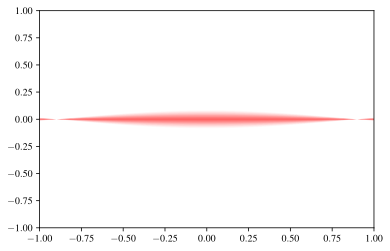

In [7]:
plot_diversity(Regression(w_mean=0, w_var=1, n_feats=1, phi=lambda x: torch.cos(x*1.75)/20))

Epoch 0: loss = 0.08217277377843857
Epoch 1000: loss = 0.004356786143034697
Epoch 2000: loss = 0.0041274819523096085
Epoch 3000: loss = 0.004339366219937801
Epoch 4000: loss = 0.004067674744874239


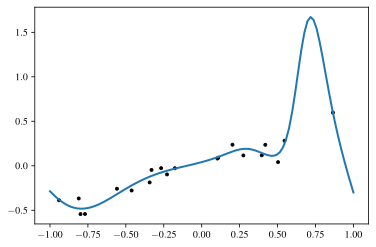

In [8]:
def init_nlm():
    basis_block = nn.Sequential(
      nn.Linear(1, 64),
      nn.GELU(),
      nn.Linear(64, 2),
      nn.GELU(),
    )
    output_layer = nn.Linear(2, 1, bias=False)
    nlm = nn.Sequential(basis_block, output_layer)
    return nlm, basis_block

def train_objective(net, x, y, lr=0.01, l2=0.0, epochs=5000, print_freq=1000):
    loss = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)
    try:
        for epoch in range(epochs):
            optimizer.zero_grad()
            l = loss(net(x), y)        
            l.backward()
            optimizer.step()
        
            if epoch % print_freq == 0:
                print('Epoch {}: loss = {}'.format(epoch, l.item()))
    except KeyboardInterrupt:
        print('Interrupted...')

nlm, basis_block = init_nlm()

x = ds.Uniform(-1.0, 1.0).sample((20,1))
y = 0.5 * x + ds.Normal(0, 0.1).sample(x.shape)
train_objective(nlm, x, y)

x_test = torch.linspace(-1, 1, 100).unsqueeze(-1)
with torch.no_grad():
  plt.plot(x_test, nlm(x_test))
  plt.scatter(x, y, c='k', s=10)

In [20]:
list(nlm.parameters())[-1]

('1.weight',
 Parameter containing:
 tensor([[ 0.7420, -1.8656]], requires_grad=True))

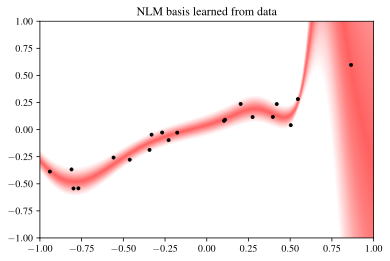

In [9]:
nlm_basis = lambda basis_block: lambda x: basis_block(x).detach()
w_mean = nlm.state_dict()['1.weight'].squeeze()

plot_diversity(Regression(w_mean=w_mean, w_var=0.1, n_feats=2, phi=nlm_basis(basis_block)))
plt.scatter(x, y, c='k', s=10)
plt.title('NLM basis learned from data')
plt.show()

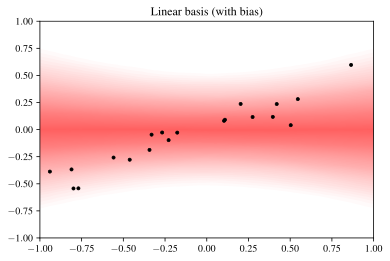

In [10]:
plot_diversity(Regression(w_mean=0, w_var=0.1, n_feats=2, phi=poly_basis(1)))
plt.scatter(x, y, c='k', s=10)
plt.title('Linear basis (with bias)')
plt.show()